# This code reproduces the LIME segmentation and applies it to all of the images in COCO train/val/test.

We start with imports:

In [2]:
from multiprocessing import Pool, get_context, Process, set_start_method
from skimage.segmentation import felzenszwalb, slic, quickshift
from scipy.ndimage.measurements import find_objects
from skimage.segmentation import mark_boundaries
from sklearn.utils import check_random_state
from torchvision import models, transforms
import matplotlib.patches as patches
from skimage.color import gray2rgb
from collections import ChainMap
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
import inspect
import sklearn
import shutil
import torch
import types
import glob
import json
import math
import time
import sys
import os

# import pycocotools COCO API
from pycocotools.coco import COCO

# handle pickle versioning issues
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
# need to install on device
from img2vec_pytorch import Img2Vec

Next, we copy over the LIME code where the segmentation is performed (along with dependencies):

In [4]:
# from https://github.com/marcotcr/lime/blob/master/lime/utils/generic_utils.py

def has_arg(fn, arg_name):
    """Checks if a callable accepts a given keyword argument.
    Args:
        fn: callable to inspect
        arg_name: string, keyword argument name to check
    Returns:
        bool, whether `fn` accepts a `arg_name` keyword argument.
    """
    if sys.version_info < (3,):
        if isinstance(fn, types.FunctionType) or isinstance(fn, types.MethodType):
            arg_spec = inspect.getargspec(fn)
        else:
            try:
                arg_spec = inspect.getargspec(fn.__call__)
            except AttributeError:
                return False
        return (arg_name in arg_spec.args)
    elif sys.version_info < (3, 6):
        arg_spec = inspect.getfullargspec(fn)
        return (arg_name in arg_spec.args or
                arg_name in arg_spec.kwonlyargs)
    else:
        try:
            signature = inspect.signature(fn)
        except ValueError:
            # handling Cython
            signature = inspect.signature(fn.__call__)
        parameter = signature.parameters.get(arg_name)
        if parameter is None:
            return False
        return (parameter.kind in (inspect.Parameter.POSITIONAL_OR_KEYWORD,
                                   inspect.Parameter.KEYWORD_ONLY))


# from https://github.com/marcotcr/lime/blob/master/lime/wrappers/scikit_image.py

class BaseWrapper(object):
    """Base class for LIME Scikit-Image wrapper
    Args:
        target_fn: callable function or class instance
        target_params: dict, parameters to pass to the target_fn
    'target_params' takes parameters required to instanciate the
        desired Scikit-Image class/model
    """

    def __init__(self, target_fn=None, **target_params):
        self.target_fn = target_fn
        self.target_params = target_params

    def _check_params(self, parameters):
        """Checks for mistakes in 'parameters'
        Args :
            parameters: dict, parameters to be checked
        Raises :
            ValueError: if any parameter is not a valid argument for the target function
                or the target function is not defined
            TypeError: if argument parameters is not iterable
         """
        a_valid_fn = []
        if self.target_fn is None:
            if callable(self):
                a_valid_fn.append(self.__call__)
            else:
                raise TypeError('invalid argument: tested object is not callable,\
                 please provide a valid target_fn')
        elif isinstance(self.target_fn, types.FunctionType) \
                or isinstance(self.target_fn, types.MethodType):
            a_valid_fn.append(self.target_fn)
        else:
            a_valid_fn.append(self.target_fn.__call__)

        if not isinstance(parameters, str):
            for p in parameters:
                for fn in a_valid_fn:
                    if has_arg(fn, p):
                        pass
                    else:
                        raise ValueError('{} is not a valid parameter'.format(p))
        else:
            raise TypeError('invalid argument: list or dictionnary expected')

    def set_params(self, **params):
        """Sets the parameters of this estimator.
        Args:
            **params: Dictionary of parameter names mapped to their values.
        Raises :
            ValueError: if any parameter is not a valid argument
                for the target function
        """
        self._check_params(params)
        self.target_params = params

    def filter_params(self, fn, override=None):
        """Filters `target_params` and return those in `fn`'s arguments.
        Args:
            fn : arbitrary function
            override: dict, values to override target_params
        Returns:
            result : dict, dictionary containing variables
            in both target_params and fn's arguments.
        """
        override = override or {}
        result = {}
        for name, value in self.target_params.items():
            if has_arg(fn, name):
                result.update({name: value})
        result.update(override)
        return result

class SegmentationAlgorithm(BaseWrapper):
    """ Define the image segmentation function based on Scikit-Image
            implementation and a set of provided parameters
        Args:
            algo_type: string, segmentation algorithm among the following:
                'quickshift', 'slic', 'felzenszwalb'
            target_params: dict, algorithm parameters (valid model paramters
                as define in Scikit-Image documentation)
    """

    def __init__(self, algo_type, **target_params):
        self.algo_type = algo_type
        if (self.algo_type == 'quickshift'):
            BaseWrapper.__init__(self, quickshift, **target_params)
            kwargs = self.filter_params(quickshift)
            self.set_params(**kwargs)
        elif (self.algo_type == 'felzenszwalb'):
            BaseWrapper.__init__(self, felzenszwalb, **target_params)
            kwargs = self.filter_params(felzenszwalb)
            self.set_params(**kwargs)
        elif (self.algo_type == 'slic'):
            BaseWrapper.__init__(self, slic, **target_params)
            kwargs = self.filter_params(slic)
            self.set_params(**kwargs)

    def __call__(self, *args):
        return self.target_fn(args[0], **self.target_params)

Next, we define a function for chunking for multiprocessing:

In [5]:
# function that splits a list into n chunks for multiprocessing
def chunk(file_list, n_chunks):
    
    # make chunks of files to be distributed across processes
    chunks = []
    chunk_size = math.ceil(float(len(file_list))/n_chunks)
    for i in range(0, n_chunks-1):
        chunks.append(file_list[i*chunk_size:(i+1)*chunk_size])
    chunks.append(file_list[(n_chunks-1)*chunk_size:])
    
    return chunks

We also define the PIL transform for generating the correct segmentation:

In [7]:
# image preprocessing from: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf   

pill_transf = get_pil_transform()


# Next, we perform segmentation and bounding box creation using the LIME code added above.

We start with a demonstration of how this works:

Number of segments: 36


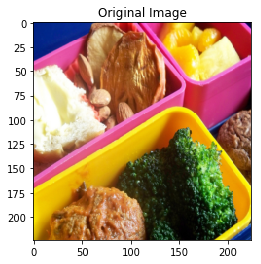

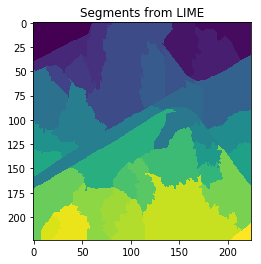

<Figure size 432x288 with 0 Axes>

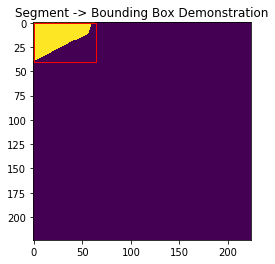

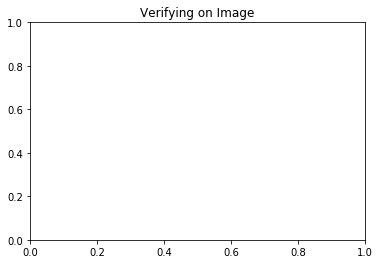

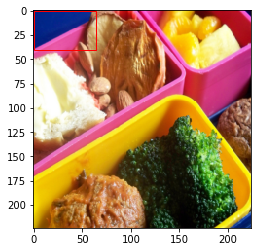

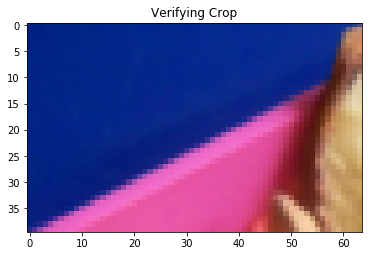

In [9]:
# let's load in COCO training and validation data
train_image_paths = sorted(glob.glob("../COCO/train2017/*.jpg"))
val_image_paths = sorted(glob.glob("../COCO/val2017/*.jpg"))

# let's now define the LIME segmentation algorithm
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                        max_dist=200, ratio=0.2)
                                        #random_seed=random_seed)


# let's first demonstrate that the segmentation works properly:
print("START NOTEBOOK DEMO")
im = Image.open(train_image_paths[0])
im = pill_transf(im)
im_arr = np.array(im)
segments = segmentation_fn(im) + 1 # note: we add 1 here because we want the background to also count as a segment!    
plt.figure()
plt.imshow(im_arr)
plt.title("Original Image")
plt.figure()
plt.title("Segments from LIME")
print("Number of segments: " + str(np.max(segments.flatten())))
plt.imshow(segments)
boxes = find_objects(segments)
plt.figure()
fig,ax = plt.subplots(1)
plt.title("Segment -> Bounding Box Demonstration")
ax.imshow(segments==1)
# for each box, we grab coordinates and plot
for box in boxes[0:1]:
    w1 = box[1].start
    w2 = box[1].stop
    h1 = box[0].start
    h2 = box[0].stop
    # create rectangle
    rect = patches.Rectangle((w1,h1),w2-w1,h2-h1,linewidth=1,edgecolor='r',facecolor='none')
    # add the patch to the Axes
    ax.add_patch(rect)
plt.figure()
plt.title("Verifying on Image")
fig,ax = plt.subplots(1)
ax.imshow(im)
rect = patches.Rectangle((w1,h1),w2-w1,h2-h1,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.figure()
plt.title("Verifying Crop")
cropped = im.crop((w1, h1, w2, h2))
plt.imshow(cropped)
print("STOP NOTEBOOK DEMO")
    

Here are the functions for performing segmentation, bounding box generation, and cropping for all of the images:

In [ ]:
def process(image_paths_list):

    # now, we iterate over all of the images and perform segmentation
    for i in range(0, len(image_paths_list)):
        
        image_path = image_paths_list[i]
        
        # open the image
        im = Image.open(image_path)
        # we now use the PIL preprocessing step that LIME uses
        im = pill_transf(im)
        im_arr = np.array(im)
        
        # if we have a 2d image, we skip for now (instead of making RGB)
        if len(im_arr.shape) < 3:
            continue

        # generate segments using LIME segmentation function
        # NOTE: we add 1 here b/c of the fact that 0 corresponds to 'background' when running find_objects()
        segments = segmentation_fn(im) + 1

        # generate bounding boxes using scipy.ndimage.measurements.find_objects
        bboxes = find_objects(segments)

        # save generated metadata 
        np.save(image_path.replace("train2017", "train2017_segments").replace(".jpg", ".npy"), segments)
        with open(image_path.replace("train2017", "train2017_bboxes").replace(".jpg", ".pkl"), 'wb') as output:
            pickle.dump(bboxes, output, -1)

        ## assertion checks to make sure the saving is working correctly ##
    #     recovered_segments = np.load(image_path.replace("train2017", "train2017_segments").replace(".jpg", ".npy"))
    #     assert np.sum(segments - recovered_segments) == 0

    #     file = open(image_path.replace("train2017", "train2017_bboxes").replace(".jpg", ".pkl"),'rb')
    #     recovered_bboxes = pickle.load(file)
    #     file.close()
    #     assert bboxes == recovered_bboxes
        ###################################################################

        # for each box, we grab coordinates and crop
        for j in range(0, len(bboxes)):
            box = bboxes[j]
            w1 = box[1].start
            w2 = box[1].stop
            h1 = box[0].start
            h2 = box[0].stop
            cropped = im.crop((w1, h1, w2, h2))

            # save cropped region
            cropped.save(image_path.replace("train2017", "train2017_crops").replace(".jpg", "_" + str(j+1) + ".jpg"), "JPEG")

        # lastly, we save the FULL image (which we need to featurize as input to the model)
        im.save(image_path.replace("train2017", "train2017_crops").replace(".jpg", "_full.jpg"), "JPEG")
            
            
        if i % 10 == 0:
            print(i)
         

Next, we generate embeddings for each of the cropped regions:

In [ ]:
def generate_embeddings(zipped):
    
    cropped_filepaths = zipped[0]
    ID = zipped[1]
        
    ct_processed = 0
        
    with torch.cuda.device(ID):        
    
        for i in range(0, len(cropped_filepaths)):
            
            cropped_filepath = cropped_filepaths[i]

            # load in img2vec
            # we choose resnet embeddings
            img2vec_resnet_50 = Img2Vec(cuda=True, model='resnet-50') 
            img2vec_resnet_18 = Img2Vec(cuda=True, model='resnet-18') 

            # open cropped image
            im = Image.open(cropped_filepath).convert('RGB')
            # generate embedding using img2vec
            embedding_resnet_50 = img2vec_resnet_50.get_vec(im, tensor=False)
            embedding_resnet_18 = img2vec_resnet_18.get_vec(im, tensor=False)
            
            np.save(cropped_filepath.replace("train2017_crops", "train2017_embeddings").replace(".jpg", "_embedding_50.npy"), embedding_resnet_50)
            np.save(cropped_filepath.replace("train2017_crops", "train2017_embeddings").replace(".jpg", "_embedding_18.npy"), embedding_resnet_18)

            if "_full" in cropped_filepath:
                ct_processed += 1
            
            if ct_processed % 10 == 0:
                print("# full images processed on GPU " + str(ID) + ": " + str(ct_processed))
                

In [ ]:
# need main for setting multiprocessing start method to spawn
if __name__ == '__main__':
    
    # let's load in COCO training and validation data
    train_image_paths = sorted(glob.glob("../COCO/train2017/*.jpg"))
    val_image_paths = sorted(glob.glob("../COCO/val2017/*.jpg"))
    
    print("# to process: " + str(len(train_image_paths)))
    
    # load COCO annotations
    with open('../COCO/annotations/instances_train2017.json') as f:
        train_metadata = json.load(f)
    with open('../COCO/annotations/instances_val2017.json') as f:
        val_metadata = json.load(f)
    
    # sets batch size for GPU inference; using 1 to prevent any memory overflow edge case in pipeline
    INFERENCE_BATCH_SIZE = 1

    # sets number of processes (be careful based on number of available cores)
    N_CPU_PROCESSES = 48

    # sets number of GPUs available
    N_GPUS = torch.cuda.device_count()

    # let's now define the LIME segmentation algorithm
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                            max_dist=200, ratio=0.2)

    # sets multiprocessing pool
    pool = Pool(N_CPU_PROCESSES)  

    # sets start method to spawn for GPU multiprocessing
    ctx = get_context('forkserver')
    
    print("Processing images (segmenting, generating bounding boxes & cropping)...")
    
    # run multiprocessing on all of the images
    pool.map(process, chunk(train_image_paths, N_CPU_PROCESSES))
    
    
    print("Done with segmentation, bounding box construction, and cropping!")
    
    print("Generating embeddings...")
    
    # grab the cropped paths
    crops = sorted(glob.glob("../COCO/train2017_crops/*.jpg"))
    
    # filter to do only the ones that haven't been processed yet
    filtered_crops = []
    for crop in crops:
        if os.path.exists(crop.replace("train2017_crops", "train2017_embeddings").replace(".jpg", "_embedding_50.npy")):
            continue
        else:
            filtered_crops.append(crop)
    
    single_GPU = False
    
    if single_GPU:
        
        generate_embeddings([filtered_crops,0])

    else:
    
        # FOR MULTIPROCESSING
        chunked_crops = chunk(filtered_crops, N_GPUS)

        # https://stackoverflow.com/questions/31386613/python-multiprocessing-what-does-process-join-do
        processes = []
        for i in range(0, N_GPUS):
            zipped = [chunked_crops[i], i]
            p = ctx.Process(target=generate_embeddings, args=(zipped,))
            p.start()
            processes.append(p)

        for process in processes:
            process.join()
